# MLP в pytorch

## Работа №2


---

ФИО: Наугольный Егор Сергеевич

---

Далее в ноутбуке будут пропущенны части кода с комментариями о том что необходимо написать. А также текстовые ячейки с вопросами, на которые вам необходимо дать ответы.

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

# Настройки для графиков
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Совет по работе**

Создавайте отдельные ячейки для ваших экспериментов. Пробуйте создавать небольшие тензоры и экспериментировать с ними, чтобы понять как работает та или иная функция и какие размерности данных вам требуются.

Когда дойдете до цикла обучения сначала пробуйте работать с одной эпохой и ограниченным набором пакетов данных, чтобы меньше времени ожидать до обнаружения ошибки.

## Загрузка данных

Из встроенных датасетов torchvision загрузите тестовую и обучающую выборки из EMNIST часть (split) Balanced или Letters, указав приобразование для изображений используя ToTensor().

In [2]:
from mlops import dataset

train_set, test_set = dataset.get_dataset()

Выведите информацию о количестве данных в обеих выборках, размерностях изображений, количестве классов и сами метки классов.

Функция `dir()` в python возвращает список допустимых атрибутов объекта, что может вам подсказать как получить часть информации о датасете.

In [3]:
train_samples_len = train_set.data.shape[0]
test_samples_len = test_set.data.shape[0]
image_shape = tuple(train_set.data[0].shape)
classes_len = len(train_set.classes)
classes_labels = train_set.classes

print(train_samples_len, test_samples_len, image_shape, classes_len, classes_labels)

124800 20800 (28, 28) 27 ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Визуализация 9 случайных образцов

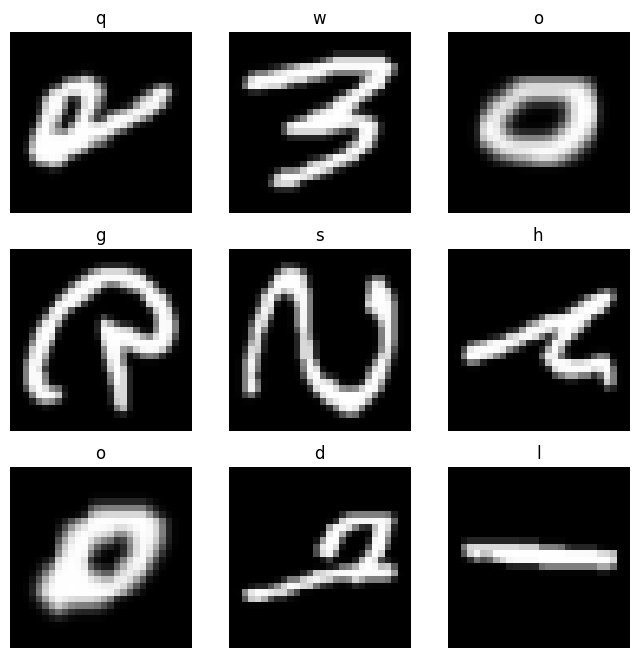

In [4]:
labels_map = dict(zip(range(len(train_set.classes)), train_set.classes))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

**По представленным образцам, что вы можете сказать о них? Есть ли в них что-то необычное и это усложнит или упростит обучение модели?** (макс. 5 баллов)

Ваш ответ:
- буквы имеют разный рукописный "шрифт"
- буквы имеют различную ориентацию (наклон/поворот)
- буквы имеют разную резкость контура. Где-то контур более четкий (m) где-то более размытый (z)

## Создание загрузчиков данных (DataLoader)

Данные при обучении модели редко передаются по одному образцу или все разом, обычно образцы объединяются в пакеты (batches) и уже они передаются на вход модели.

Размер пакета (batch size) часто выбирается как $2^n$ (16, 32, 64, 128) и часто это зависит от доступной памяти.

Загрузчики данных будут использоваться при обучении и тестировании модели и когда все пакеты были перебраны в датасете, это считается одной эпохой обучения. Чтобы между эпохами модель на обучалась на одинаковых пакетах их перемешивают (shuffle). При тестировании это не имеете разницы.

Поэтому выберите один из размеров пакета при создании загрузчиков и для обучающего загрузчика используйте перемешивание, а тестового нет.

In [5]:
from mlops import features

batch_size = 2 ** 4
train_dataloader, test_dataloader = features.get_dataloaders(train_set, test_set, batch_size)

**Опишите размерности данных одного пакета.** (макс. 10 баллов)

Ваш ответ: (16, 1, 28, 28) (batch_size, channels, height, width

## Многослойный перцептрон

В этой работе мы еще не будем использовать все возможности pytorch по построению нейронной сети например `nn.Sequential` или `nn.Module`, это будет рассмотрено в следующем задании.

Ваша задача в этой работе используя функции из модуля `torch.nn.functional` `linear` и `relu`собрать цепочку вычислений для получения выходных значений. Во входном слое не забудьте использовать для изображений `.flatten()`. Чтобы вы могли использовать батчи, вам надо подумать какую часть тензора требуется сделать "плоской".

Вывод с последнего слоя преобразуйте с помощью Softmax.

Перед тем как использовать функцию потерь от значений из Softmax возьмите логарифм (`log()`) В качестве функции потерь используйте negative log likelihood loss `nll`. Почитайте какие данные ей требуются на вход, Вам придется самостоятельно подготовить тензор с помощью `F.one_hot()`.

Параметры для функций, которые будут оптимизироваться, вы создаете самостоятельно с помощью `xavier_normal`, а отклонения (bias)
с помощью `torch.randn()` с нужными размерностями.

Не забывайте, что для использования `backward()`, у оптимизируемых параметров должен быть поднят флаг requires_grad.

In [6]:
def xavier_normal(F_in, F_out):
    limit = np.sqrt(6 / float(F_in + F_out))
    W = np.random.uniform(low=-limit, high=limit, size=(F_in, F_out))
    return torch.from_numpy(W).type(torch.float32).requires_grad_()

In [7]:
from torch.nn.functional import *
input_size = 28 * 28 
hidden_size = 128
output_size = classes_len


# Инициализация параметров
w1 = xavier_normal(hidden_size, input_size)
b1 = torch.randn(hidden_size, requires_grad=True)

w2 = xavier_normal(output_size, hidden_size)
b2 = torch.randn(output_size, requires_grad=True)

# Функция прямого прохода
def forward(x):
    x = x.flatten(start_dim=1)  # преобразование тензора в плоский
    z1 = linear(x, w1, b1)   # линейное преобразование
    a1 = relu(z1)            # ф. актив. ReLU
    z2 = linear(a1, w2, b2)
    return log_softmax(z2, dim=1)

**Опишите идею инициализации Ксавье. Почему могут быть проблемы с использованием torch.randn()?** (макс. 5 баллов)

Ваш ответ:

**Сколько параметров в вашей модели?** (макс. 5 баллов)

Ваш ответ: 
- 28 * 28 (входной слой) * 128 (скрытый слой) + 128 (биасы) = 100_480 - первый слой
- 128 * 26 (выходной слой) + 26 (биасы) 3_354

Итого: 100_480 + 3_354 = 103_834

Обновите параметры модели. Для обновления параметров не забудьте использовать контекст torch.no_grad(). Скорость обучения (lr) для начала можно взять равным 1e-3.

In [8]:
# w -= w.grad * lr

**Что произойдет если не использовать этот контекст?** (макс. 5 баллов)

Ваш ответ:

## Цикл обучения

Напишите цикл, который за заданное количество эпох оптимизирует параметры вашей модели.

1. Делается прямой проход и получаются значения работы вашей модели.
1. Рассчитывается значение потерь.
1. Расчитываются градиенты.
1. Обновляются параметры с учетом скорости обучения.

Каждые 100 пройденных батчей выводите значение потерь `loss.item()`.

Также в рамках каждой эпохи оценивайте потери и точность работы вашей модели.

Для подсчета количества правильных предсказаний можно использовать следующий код внутри цикла:

```python
correct += (pred.argmax(1) == y).type(torch.float).sum().item()
```

...и снаружи цикла:

```python
correct /= len(dataloader.dataset)
```

In [9]:
from mlops.modeling.train import Model


input_size = 28 * 28
hidden_size = 128
output_size = 27

learning_rate = 0.001  # 1e-3
epochs = 10

model = Model(input_size, hidden_size, output_size, learning_rate)

for epoch in range(epochs):
    correct = 0
    for batch_idx, (x, y) in enumerate(train_dataloader):
        
        y_pred = model.predict(x)
        loss = model.back_propagate(y_pred, y)
        
        # # Прямой проход
        # y_pred = forward(x)
        # loss = nll_loss(y_pred, y)
        # 
        # # Обратное распространение
        # loss.backward()
        # 
        # # Обновление параметров
        # with torch.no_grad():
        #     w1 -= learning_rate * w1.grad
        #     b1 -= learning_rate * b1.grad
        #     w2 -= learning_rate * w2.grad
        #     b2 -= learning_rate * b2.grad
        # 
        #     # Сброс градиентов
        #     w1.grad.zero_()
        #     b1.grad.zero_()
        #     w2.grad.zero_()
        #     b2.grad.zero_()

        correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        if batch_idx % 1000 == 0:
            print(f"e: {epoch + 1}/{epochs}, b: {batch_idx}/{len(train_dataloader)}, l: {round(loss.item(), 3)}")
            
    accuracy = correct / len(train_dataloader.dataset)
    print('accuracy:', accuracy)


e: 1/10, b: 0/7800, l: 4.015
e: 1/10, b: 1000/7800, l: 2.927
e: 1/10, b: 2000/7800, l: 2.578
e: 1/10, b: 3000/7800, l: 2.151
e: 1/10, b: 4000/7800, l: 2.308
e: 1/10, b: 5000/7800, l: 1.926
e: 1/10, b: 6000/7800, l: 2.013
e: 1/10, b: 7000/7800, l: 1.574
accuracy: 0.4245833333333333
e: 2/10, b: 0/7800, l: 1.545
e: 2/10, b: 1000/7800, l: 1.534
e: 2/10, b: 2000/7800, l: 0.764
e: 2/10, b: 3000/7800, l: 1.074
e: 2/10, b: 4000/7800, l: 1.23
e: 2/10, b: 5000/7800, l: 1.66
e: 2/10, b: 6000/7800, l: 1.605
e: 2/10, b: 7000/7800, l: 1.502
accuracy: 0.5974198717948718
e: 3/10, b: 0/7800, l: 1.077
e: 3/10, b: 1000/7800, l: 1.604
e: 3/10, b: 2000/7800, l: 1.85
e: 3/10, b: 3000/7800, l: 1.471
e: 3/10, b: 4000/7800, l: 1.483
e: 3/10, b: 5000/7800, l: 1.004
e: 3/10, b: 6000/7800, l: 1.231
e: 3/10, b: 7000/7800, l: 0.91
accuracy: 0.6424439102564102
e: 4/10, b: 0/7800, l: 1.224
e: 4/10, b: 1000/7800, l: 1.185
e: 4/10, b: 2000/7800, l: 1.332
e: 4/10, b: 3000/7800, l: 1.739
e: 4/10, b: 4000/7800, l: 1.264
e

**Какова точность работы вашей модели?** (макс. 30 баллов)

Ваш ответ: 


Кол-во эпох: 10,
Скорость обучения: 0.001,
Точность: 0.73

## Подбор гиперпараметров

Теперь когда у вас есть рабочый код для модели и ее обучения, попробуйте разные варианты скорости обучения, количества параметров в скрытых слоя модели, количества эпох, размера батчей.

In [10]:
from torch.nn.functional import *

def test(epochs, learning_rate):
    # Инициализация параметров
    w1 = xavier_normal(hidden_size, input_size)
    b1 = torch.randn(hidden_size, requires_grad=True)
    
    w2 = xavier_normal(output_size, hidden_size)
    b2 = torch.randn(output_size, requires_grad=True)
    
    # Функция прямого прохода
    def forward(x):
        x = x.flatten(start_dim=1)
        z1 = linear(x, w1, b1)
        a1 = relu(z1)
        z2 = linear(a1, w2, b2)
        log_probs = log_softmax(z2, dim=1)
        return log_probs

    correct = 0
    for epoch in range(epochs):
        correct = 0
        for batch_idx, (x, y) in enumerate(train_dataloader):
            # Прямой проход
            y_pred = forward(x)
            loss = nll_loss(y_pred, y)
    
            # Обратное распространение
            loss.backward()
    
            # Обновление параметров
            with torch.no_grad():
                w1 -= learning_rate * w1.grad
                b1 -= learning_rate * b1.grad
                w2 -= learning_rate * w2.grad
                b2 -= learning_rate * b2.grad
    
                # Сброс градиентов
                w1.grad.zero_()
                b1.grad.zero_()
                w2.grad.zero_()
                b2.grad.zero_()
    
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
        print(f"{epoch + 1} / {epochs}")
    return correct / len(train_dataloader.dataset)

**Сколько комбинаций гиперпараметров вы попробовали? Напишите их и точности, которые были при них получены.** (макс. 40 баллов)

Ваш ответ: 8 комбинаций.

| **№** | **epoch** | **learning_rate** | **accuracy** |
|:-----:|:---------:|:-----------------:|:------------:|
|   1   |     5     |        0.02       |     0.877    |
|   2   |     10    |        0.01       |     0.882    |
|   3   |     5     |        0.05       |     0.893    |
|   4   |     5     |        0.08       |     0.892    |
|   5   |     5     |        0.1        |     0.888    |
|   6   |     10    |        0.1        |     0.905    |
|   7   |     15    |        0.5        |     0.820    |
|   8   |     30    |       0.001       |     0.824    |


Наиболее высокая точность у эксперимента №6 - 90% (10 эпох, learning_rate 0.1)
Самый худший результат показал эксперимент №7 - 82% (15 эпох, learning_rate 0.5)
Также плохой результат показал эксперимент №8 - 82% (30 эпох, learning_rate 0.5)

Можно сделать вывод, что многократное повторение одной и той же обучающей выборки не приводит к повышению точности модели.
Текущая серия экспериментов показала, что оптимальным является небольшое количество эпох с умеренным шагом обучения.



In [11]:
test(5, 0.02)

KeyboardInterrupt: 

In [ ]:
test(10, 0.01)

In [ ]:
test(5, 0.05)

In [ ]:
test(5, 0.08)

In [ ]:
test(5, 0.1)

In [ ]:
test(10, 0.1)

In [ ]:
test(15, 0.5)

In [ ]:
test(30, 0.001)